In [20]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

folder = '../../data/dev/data'
plot_folder = 'plots/dev'

make_dir(plot_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:

metrics_df = pd.read_parquet(os.path.join(folder, 'metrics.parquet'))
confusion_matrix_df = pd.read_parquet(os.path.join(folder, 'confusion_matrix.parquet'))
synthethetic_df = pd.read_parquet(os.path.join(folder, 'synthetic_predicitions.parquet'))

In [22]:
metrics_df.columns

Index(['name', 'value', 'cv_split', 'epoch', 'set'], dtype='object')

In [23]:
metrics_df.name.unique()

array(['loss', 'mean_absolute_error', 'accuracy'], dtype=object)

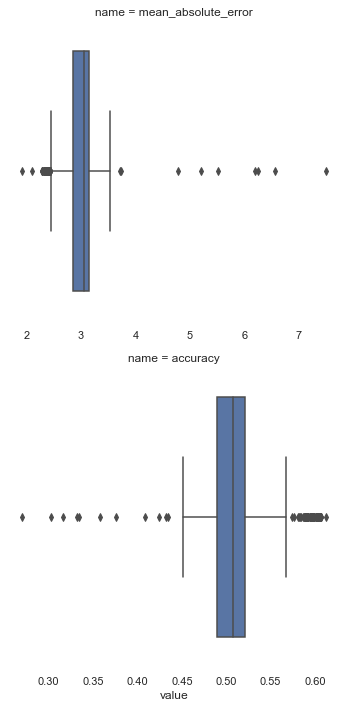

In [24]:
w = (
    (metrics_df['name'].isin(['accuracy', 'mean_absolute_error'])) &
    (metrics_df['set'] == 'test')
)
df = metrics_df[w]
# df = df.sort_values('y_ordinal')
sns.catplot(data=df, x='value', row='name', orient='h', kind='box', sharex=False)

In [25]:
# y_ordinal = [True, False]
# cont_ordinal = True
# pun_ordinal = False
# int_ordinal = True

<AxesSubplot:xlabel='y_pred', ylabel='y_true'>

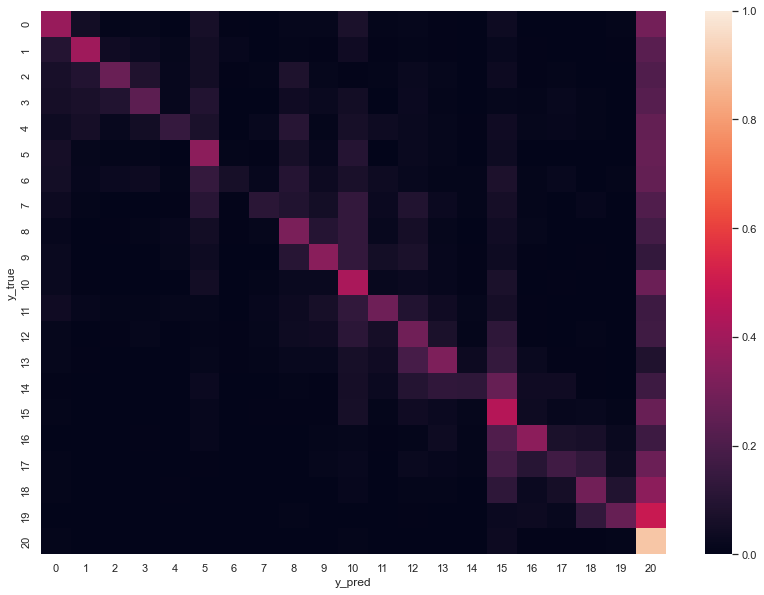

In [26]:
# Todo: double check the normalisation

cm_g_df = confusion_matrix_df.groupby(['set', 'y_true', 'y_pred'])['value'].sum().reset_index()
cm_g_df['fraction'] = cm_g_df['value'] / cm_g_df.groupby(['set', 'y_true'])['value'].transform('sum')
cm = cm_g_df.pivot_table(index=['set', 'y_true'], columns='y_pred', values='fraction')

plt.figure(figsize=(14,10))
sns.heatmap(cm.loc['test'], vmin=0, vmax=1)
# plt.savefig(os.path.join(plot_folder, 'confusion_matrix.jpg'), dpi=300, transparent=False)

<AxesSubplot:xlabel='y_pred', ylabel='y_true'>

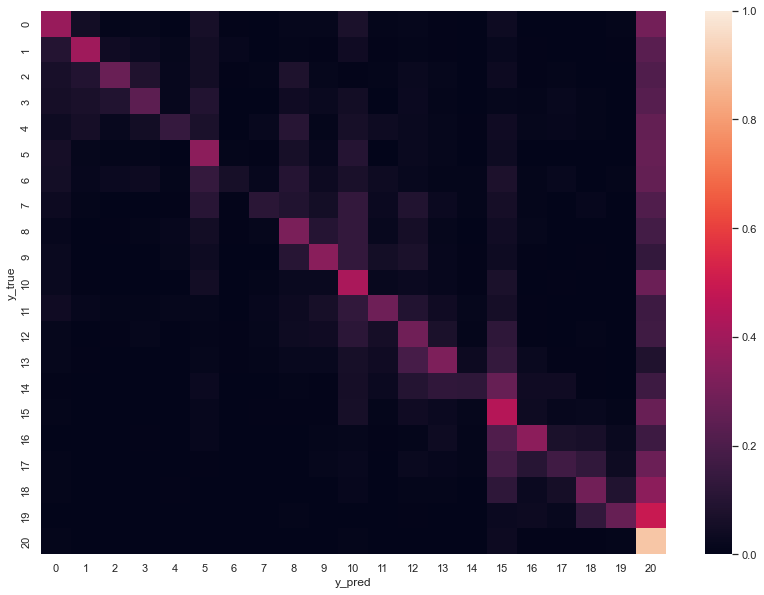

In [27]:
# Todo: double check the normalisation

cm_g_df = confusion_matrix_df.groupby(['set', 'y_true', 'y_pred'])['value'].sum().reset_index()
cm_g_df['fraction'] = cm_g_df['value'] / cm_g_df.groupby(['set', 'y_true'])['value'].transform('sum')
cm = cm_g_df.pivot_table(index=['set', 'y_true'], columns='y_pred', values='fraction')

plt.figure(figsize=(14,10))
sns.heatmap(cm.loc['test'], vmin=0, vmax=1)

<AxesSubplot:xlabel='prev_punishment', ylabel='prev_contribution'>

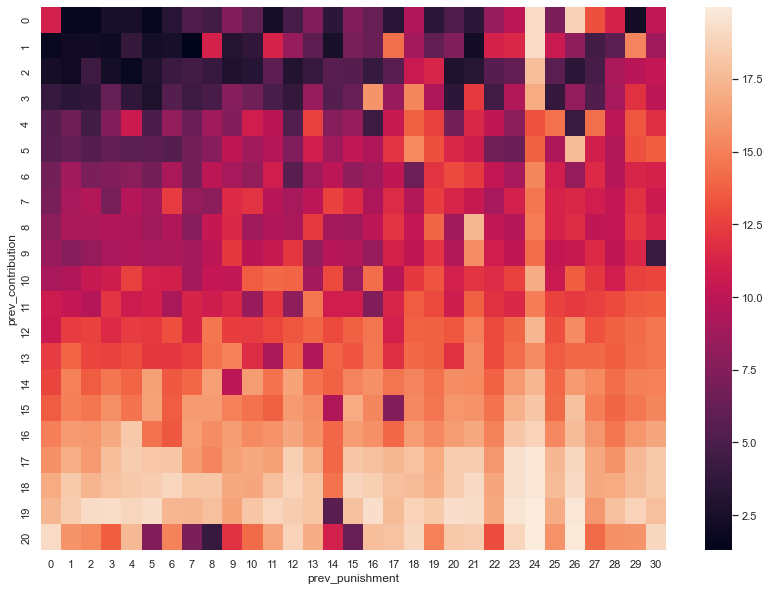

In [28]:
y_ordinal = False

df = synthethetic_df.copy()
df = df.groupby(['prev_punishment', 'prev_contribution', 'contribution'])[['proba']].mean().reset_index()

if y_ordinal:
    df['exp_contribution'] = df['proba']
else:
    df['exp_contribution'] = df['contribution'] * df['proba']

df['exp_manager_payoff'] = (df['contribution'] * 1.6 - df['prev_punishment']) * df['proba']

df[['best_exp_contribution', 'best_exp_manager_payoff']] = df[['exp_contribution', 'exp_manager_payoff']] == df.groupby(['prev_contribution'])[['exp_contribution', 'exp_manager_payoff']].transform('max')
# df[['best_exp_contribution', 'best_exp_manager_payoff']] = df[['max_exp_contribution', 'max_exp_manager_payoff']] == df[['exp_contribution', 'exp_manager_payoff']]

dfg = df.groupby(['prev_contribution', 'prev_punishment'])[['exp_contribution', 'exp_manager_payoff']].sum()
dfg = dfg.reset_index()


# df = dfg[w].groupby(['set', 'y_true', 'y_pred'])['value'].sum().reset_index()
# df['fraction'] = df['value'] / cm_g_df.groupby(['set', 'y_true'])['value'].transform('sum')
cm = dfg.pivot_table(index=['prev_contribution'], columns='prev_punishment', values='exp_contribution')

plt.figure(figsize=(14,10))
sns.heatmap(cm)

<AxesSubplot:xlabel='prev_punishment', ylabel='prev_contribution'>

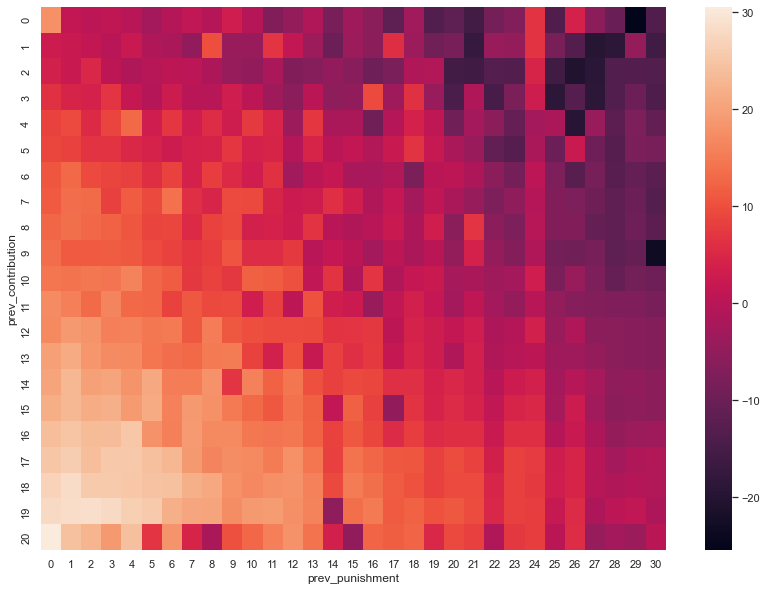

In [29]:
cm = dfg.pivot_table(index=['prev_contribution'], columns='prev_punishment', values='exp_manager_payoff')

plt.figure(figsize=(14,10))
sns.heatmap(cm)

<AxesSubplot:xlabel='defect', ylabel='punishment'>

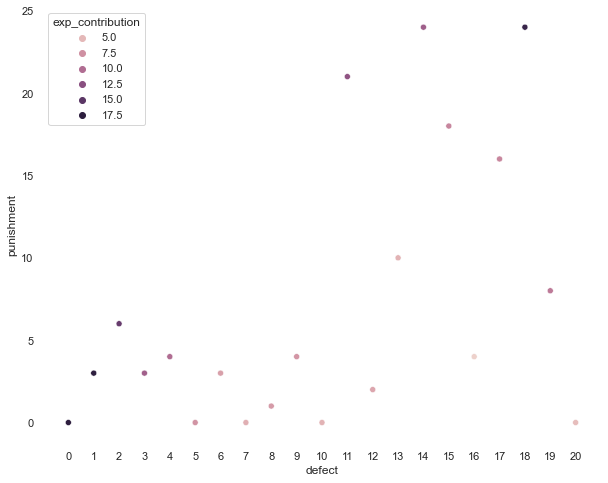

In [30]:
df3 = df[df['best_exp_manager_payoff']].copy()
df3['defect'] = (20-df3['prev_contribution'])
df3['punishment'] = df['prev_punishment']
df3['exp_net_contribution'] = df3['exp_manager_payoff']
df3 = df3.sort_values('defect')
df3['defect'] = df3['defect'].astype(str)

plt.figure(figsize=(10,8))
sns.scatterplot(data=df3, x='defect', y='punishment', hue='exp_contribution')

In [31]:
contribution_punishment_map = th.tensor(df3.sort_values('prev_contribution')['prev_punishment'].values)

In [32]:
# from aimanager.model.neural.random import RandomArtificialHumans

%load_ext autoreload
%autoreload 2

artificial_humans = "../../data/dev/data/model.pt"

import torch as th
from aimanager.model.environment import ArtificialHumanEnv
from aimanager.model.artificial_humans import ArtificialHuman


device = th.device('cpu')
rec_device = th.device('cpu')
# rah = RandomArtificialHumans(device=device, max_contribution=20)
artifical_humans = ArtificialHuman.load(artificial_humans)

env = ArtificialHumanEnv(
    artifical_humans=artifical_humans, n_agents=4, n_contributions=21, n_punishments=31, episode_steps=16, device=device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:

rec = {
    'value': [],
    'name': [],
    'round_number': [],
    'episode': [],
    'player_id': [],
}

for i in range(45):
    state = env.init_episode()
    done = False
    rn = 0
    while not done:
        contributions = state['contributions']
        punishments = contribution_punishment_map[contributions]
        # punishments = th.randint(0, 31, (4,), device=device)
        state, reward, done = env.step(punishments)

        common_good = contributions * 1.6 - punishments

        rec['value'].extend(contributions.tolist()+punishments.tolist()+common_good.tolist())
        rec['name'].extend(['contributions']*4 + ['punishments']*4 + ['common_good']*4)
        rec['episode'].extend([i]*12)
        rec['round_number'].extend([rn]*12)
        rec['player_id'].extend([0,1,2,3]*3)
        rn += 1
        env.next_step()

<AxesSubplot:xlabel='round_number', ylabel='value'>

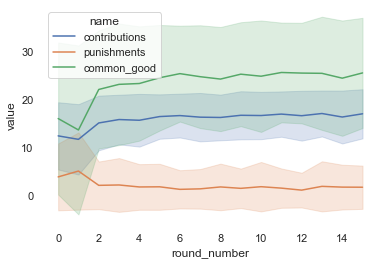

In [34]:
df = pd.DataFrame(rec)

sns.lineplot(data=df, x='round_number', hue='name', y='value', ci='sd')

In [35]:
df.to_parquet(os.path.join(folder, 'artificial_human_simulation.parquet'))